<a href="https://colab.research.google.com/github/Zardian18/Celeb-Faces-Comparision/blob/master/WGAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-24 08:33:38--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-24 08:33:38 (25.3 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
! kaggle datasets download -d jessicali9530/celeba-dataset

 98% 1.30G/1.33G [00:08<00:00, 188MB/s]
100% 1.33G/1.33G [00:08<00:00, 170MB/s]


In [ ]:
!unzip celeba-dataset.zip

In [8]:
train_data = utils.image_dataset_from_directory(
    "/content/img_align_celeba",
    labels= None,
    color_mode= "rgb",
    image_size=(64,64),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 202599 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

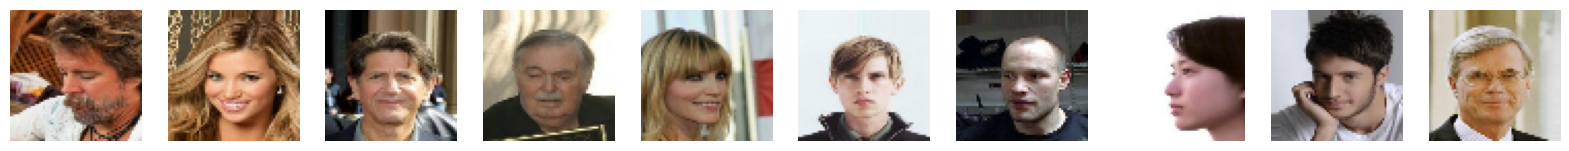

In [9]:
display(sample_batch(train_data))

In [11]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

train = train_data.map(lambda x: preprocess(x))

## Approach 1: WGAN-GP

In [14]:
critic_input = layers.Input(shape=(64, 64, 3))

x = layers.Conv2D(32, 5, strides=2, padding='same')(critic_input)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(64, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(512, 5, strides=2, padding='same')(x)
x = layers.LayerNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

critic_output = layers.Dense(1)(x)

critic = models.Model(critic_input, critic_output)
critic.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 layer_normalization_3 (Lay  (None, 16, 16, 64)        128       
 erNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                           

In [17]:
generator_input = layers.Input(shape=(200,))

x = layers.Dense(4 * 4 * 256, use_bias=False)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Reshape((4, 4, 256))(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(256, (5, 5), strides=1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(128, (5, 5), strides=1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(64, (5, 5), strides=1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


x = layers.UpSampling2D(size=2)(x)
x = layers.Conv2DTranspose(3, (5, 5), strides=1, padding='same', activation='tanh', use_bias=False)(x)

generator = models.Model(generator_input, x)
generator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_5 (Dense)             (None, 4096)              819200    
                                                                 
 batch_normalization_10 (Ba  (None, 4096)              16384     
 tchNormalization)                                               
                                                                 
 re_lu_10 (ReLU)             (None, 4096)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_10 (UpSampli  (None, 8, 8, 256)         0         
 ng2D)                                                     

In [18]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [19]:
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=200,
    critic_steps=3,
    gp_weight=10,
)

In [20]:
wgangp.compile(
    c_optimizer = optimizers.Adam(learning_rate= 0.0005, beta_1 = 0.5, beta_2 = 0.99),
    g_optimizer = optimizers.Adam(learning_rate = 0.0005, beta_1 = 0.5, beta_2 = 0.99),
)

In [25]:
class ImageGenerator_wgan(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
            cmap=None,
        )


In [26]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [23]:
! mkdir output/

Epoch 1/15
1583/1583 [==============================] - ETA: 0s - c_loss: -13.6289 - c_wass_loss: -16.1084 - c_gp: 0.2480 - g_loss: 13.8641
Saved to ./output/generated_img_000.png


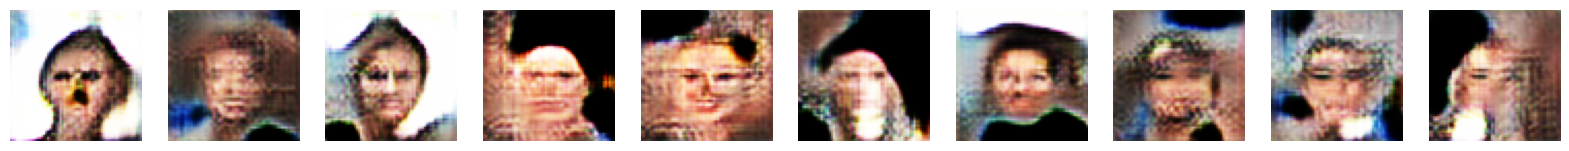

1583/1583 [==============================] - 994s 612ms/step - c_loss: -13.6289 - c_wass_loss: -16.1084 - c_gp: 0.2480 - g_loss: 13.8641
Epoch 2/15
1583/1583 [==============================] - ETA: 0s - c_loss: -5.4647 - c_wass_loss: -6.1049 - c_gp: 0.0640 - g_loss: -12.8420
Saved to ./output/generated_img_001.png


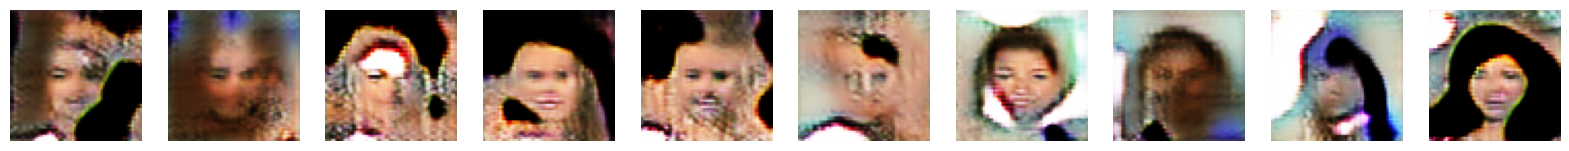

1583/1583 [==============================] - 964s 609ms/step - c_loss: -5.4647 - c_wass_loss: -6.1049 - c_gp: 0.0640 - g_loss: -12.8420
Epoch 3/15
1583/1583 [==============================] - ETA: 0s - c_loss: -4.7376 - c_wass_loss: -5.2591 - c_gp: 0.0521 - g_loss: -9.8600
Saved to ./output/generated_img_002.png


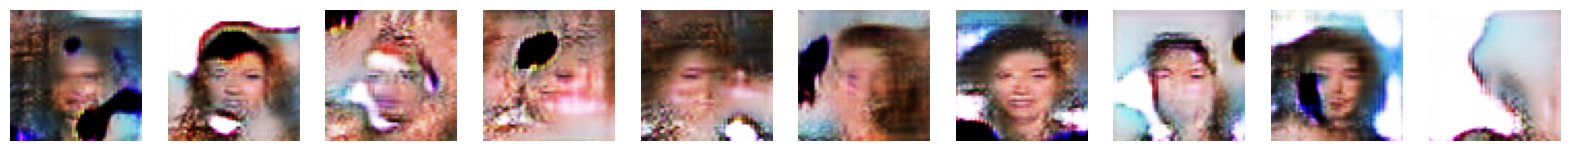

1583/1583 [==============================] - 964s 609ms/step - c_loss: -4.7376 - c_wass_loss: -5.2591 - c_gp: 0.0521 - g_loss: -9.8600
Epoch 4/15
1583/1583 [==============================] - ETA: 0s - c_loss: -4.0697 - c_wass_loss: -4.5228 - c_gp: 0.0453 - g_loss: -6.2081
Saved to ./output/generated_img_003.png


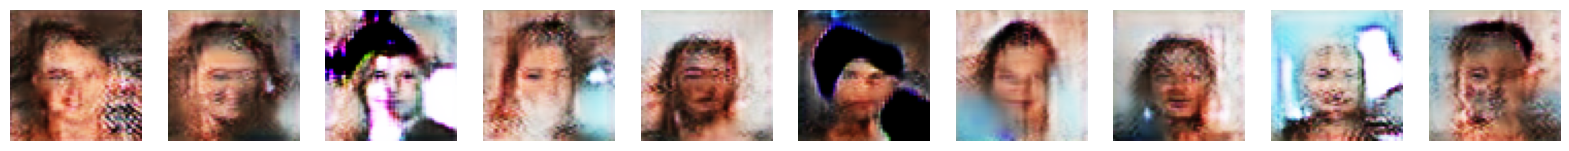

1583/1583 [==============================] - 963s 608ms/step - c_loss: -4.0697 - c_wass_loss: -4.5228 - c_gp: 0.0453 - g_loss: -6.2081
Epoch 5/15
1583/1583 [==============================] - ETA: 0s - c_loss: -3.4238 - c_wass_loss: -3.7733 - c_gp: 0.0350 - g_loss: -45.4946
Saved to ./output/generated_img_004.png


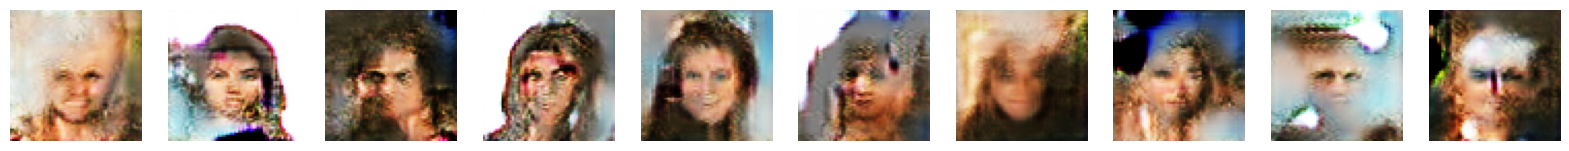

1583/1583 [==============================] - 962s 608ms/step - c_loss: -3.4238 - c_wass_loss: -3.7733 - c_gp: 0.0350 - g_loss: -45.4946
Epoch 6/15
1583/1583 [==============================] - ETA: 0s - c_loss: -2.7796 - c_wass_loss: -3.0760 - c_gp: 0.0296 - g_loss: 1.9523
Saved to ./output/generated_img_005.png


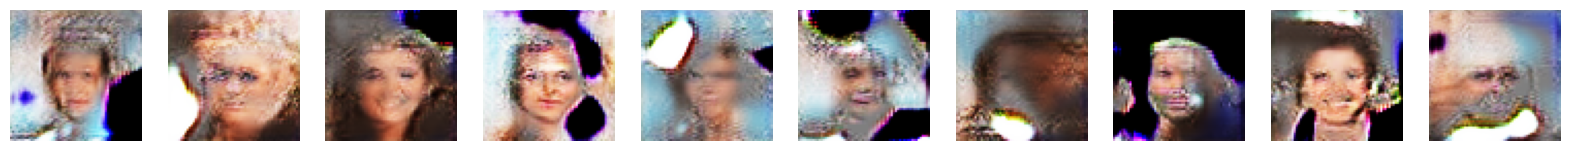

1583/1583 [==============================] - 963s 608ms/step - c_loss: -2.7796 - c_wass_loss: -3.0760 - c_gp: 0.0296 - g_loss: 1.9523
Epoch 7/15
1583/1583 [==============================] - ETA: 0s - c_loss: -2.3656 - c_wass_loss: -2.6296 - c_gp: 0.0264 - g_loss: 8.7032
Saved to ./output/generated_img_006.png


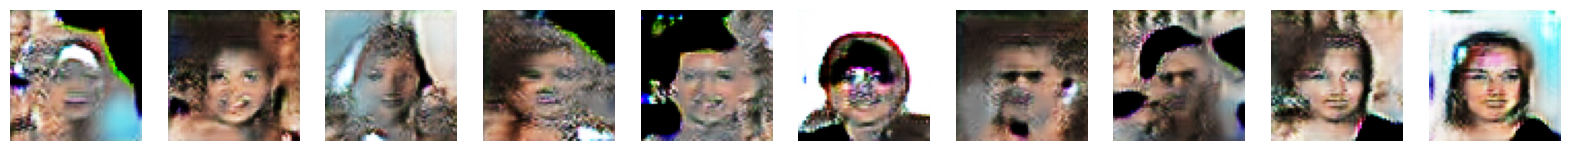

1583/1583 [==============================] - 963s 608ms/step - c_loss: -2.3656 - c_wass_loss: -2.6296 - c_gp: 0.0264 - g_loss: 8.7032
Epoch 8/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.7360 - c_wass_loss: -1.9597 - c_gp: 0.0224 - g_loss: -88.1965
Saved to ./output/generated_img_007.png


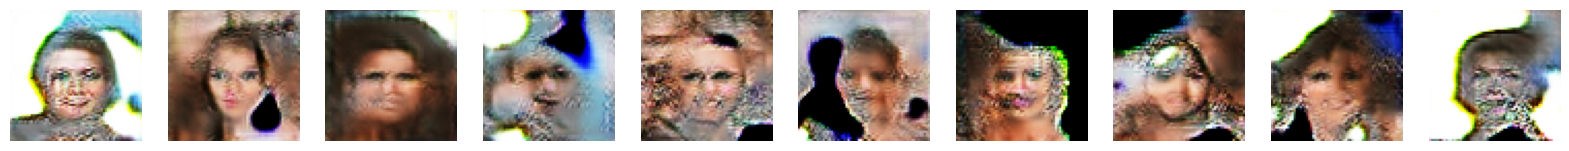

1583/1583 [==============================] - 962s 607ms/step - c_loss: -1.7360 - c_wass_loss: -1.9597 - c_gp: 0.0224 - g_loss: -88.1965
Epoch 9/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.5799 - c_wass_loss: -1.8042 - c_gp: 0.0224 - g_loss: -30.1006
Saved to ./output/generated_img_008.png


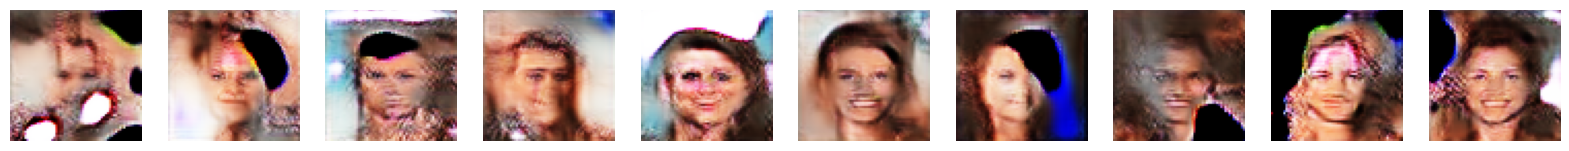

1583/1583 [==============================] - 961s 607ms/step - c_loss: -1.5799 - c_wass_loss: -1.8042 - c_gp: 0.0224 - g_loss: -30.1006
Epoch 10/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.5360 - c_wass_loss: -1.7600 - c_gp: 0.0224 - g_loss: 68.6925
Saved to ./output/generated_img_009.png


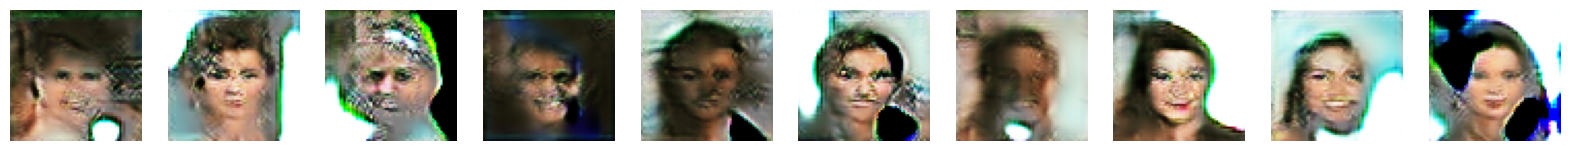

1583/1583 [==============================] - 962s 607ms/step - c_loss: -1.5360 - c_wass_loss: -1.7600 - c_gp: 0.0224 - g_loss: 68.6925
Epoch 11/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.4450 - c_wass_loss: -1.6195 - c_gp: 0.0174 - g_loss: 2.2135
Saved to ./output/generated_img_010.png


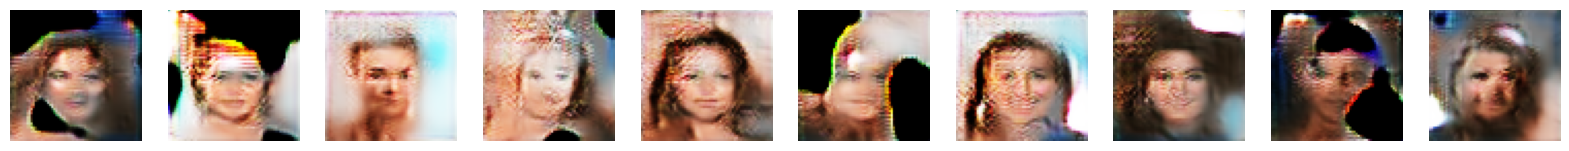

1583/1583 [==============================] - 964s 608ms/step - c_loss: -1.4450 - c_wass_loss: -1.6195 - c_gp: 0.0174 - g_loss: 2.2135
Epoch 12/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.3954 - c_wass_loss: -1.5672 - c_gp: 0.0172 - g_loss: 8.6523
Saved to ./output/generated_img_011.png


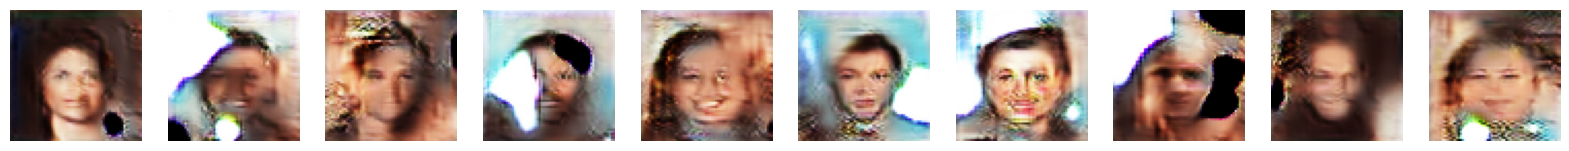

1583/1583 [==============================] - 963s 608ms/step - c_loss: -1.3954 - c_wass_loss: -1.5672 - c_gp: 0.0172 - g_loss: 8.6523
Epoch 13/15
1583/1583 [==============================] - ETA: 0s - c_loss: -1.2614 - c_wass_loss: -1.4317 - c_gp: 0.0170 - g_loss: 57.3016
Saved to ./output/generated_img_012.png


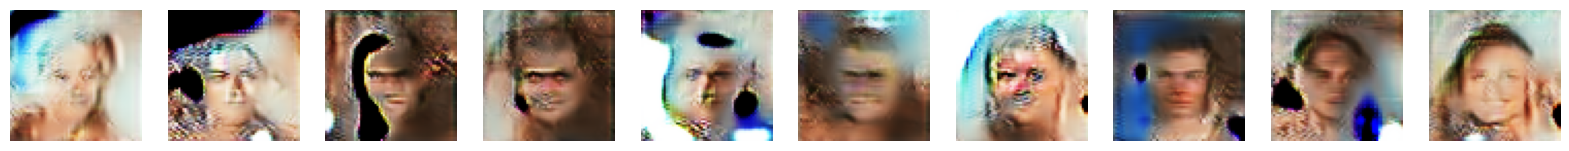

1583/1583 [==============================] - 963s 608ms/step - c_loss: -1.2614 - c_wass_loss: -1.4317 - c_gp: 0.0170 - g_loss: 57.3016
Epoch 14/15
 900/1583 [================>.............] - ETA: 6:54 - c_loss: -1.2064 - c_wass_loss: -1.3446 - c_gp: 0.0138 - g_loss: 64.0097

In [ ]:
wgangp.fit(
    train,
    epochs=15,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator_wgan(num_img=10, latent_dim=200),
    ],
)